In [1]:
import pandas as pd
import numpy as np
import sys
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
sys.path.append('../')
from src.models import street_view_cnn
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

### Input Data Prep

In [3]:
sam1= pd.read_csv('../labels/training_labels_updated_111219.csv')
sam2 = pd.read_csv('../labels/additional_training_labels_120319.csv')
sample=pd.concat([sam1, sam2], axis = 0)
assert sample.shape[0] == sam1.shape[0] + sam2.shape[0]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [4]:
# add some formatting for the labels that will be used 
sample['AERIAL_Driveway'] = sample['AERIAL_Driveway'].astype('int').astype('str')
sample['GSV_Driveway'] = sample['GSV_Driveway'].astype('int').astype('str')

In [5]:
# now split into train and validation (calling it test here)
train_data, test_data = train_test_split(sample, test_size = 0.3, random_state = 100)
y_column = 'GSV_Driveway'

In [6]:
train_data.groupby(y_column).aggregate({'MBL':len})

,MBL
GSV_Driveway,
0,75
1,280
2,100


In [7]:
test_data.groupby(y_column).aggregate({'MBL':len})

,MBL
GSV_Driveway,
0,34
1,135
2,26


In [8]:
# artificially oversample the minority class - TEST
zero_class = test_data[test_data[y_column] == '0']
one_class = test_data[test_data[y_column] == '1']
two_class = test_data[test_data[y_column] == '2']

test_data = one_class.append(zero_class)
for i in range(one_class.shape[0]//zero_class.shape[0]):
    test_data = test_data.append(zero_class)

for i in range(one_class.shape[0]//two_class.shape[0]):
    test_data = test_data.append(two_class)

In [9]:
# artificially oversample the minority class - TRAINING
zero_class = train_data[train_data[y_column] == '0']
one_class = train_data[train_data[y_column] == '1']
two_class = train_data[train_data[y_column] == '2']

train_data = one_class.append(zero_class)
for i in range(one_class.shape[0]//zero_class.shape[0] -1):
    train_data = train_data.append(zero_class)

for i in range(one_class.shape[0]//two_class.shape[0]):
    train_data = train_data.append(two_class)

In [10]:
train_data.groupby(y_column).aggregate({'MBL':len})

,MBL
GSV_Driveway,
0,225
1,280
2,200


In [11]:
test_data.groupby(y_column).aggregate({'MBL':len})

,MBL
GSV_Driveway,
0,136
1,135
2,130


### Modelling

In [12]:
# set input params
sv_image_dim = (256, 256, 3)
lr = 1e-4
batch_size = 64
val_batch_size = 64

In [14]:
# define optimizer - adam 
optimizer = keras.optimizers.Adam(lr=lr)

# define learning rate decay method - two options
# lr_decay = tensorflow.keras.callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (0.9 ** epoch)) 
lr_decay = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.01, 
                                                        patience=2, 
                                                        verbose=True, 
                                                        mode='auto',
                                                        min_delta=0.0001, 
                                                        cooldown=1, 
                                                        min_lr=1e-6)

# define loss - cat xentropy
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.2) #smoothed labels

# define pretrained model 
pretrained_model = keras.applications.InceptionResNetV2(include_top=False, input_shape=sv_image_dim, pooling = 'avg')
print('number of layers in pretrained model: ', len(pretrained_model.layers))

# I tried unfreezing none to some - more fine tuning required here but not sure it makes much of a diff atm
for layer in pretrained_model.layers[:-100]:
    layer.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
number of layers in pretrained model:  781


In [15]:
# build model using function from models.py
model = street_view_cnn(pretrained_model, 
                        image_dim = sv_image_dim, 
                        optimizer = optimizer,
                        loss = loss,
                        n_classes=3,
                        activation = 'softmax',
                        metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
satellite_image_input (Input [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 1536)              54336736  
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               307400    
_________________________________________________________________
batch_normalization_203 (Bat (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0     

### Generator

In [16]:
# inputs to generator
image_dir = '../data/training/sv_images/'
x_column = 'gsv_filename'
y_column = 'GSV_Driveway'
color_mode = 'rgb'

In [17]:
gen_obj = ImageDataGenerator(rescale=1.0/255.0, 
                                    zoom_range = 0.2 #adding zoom range as some images are super zoomed in/out
                            ) 

## train
train_generator = gen_obj.flow_from_dataframe(train_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=batch_size, 
                                            shuffle=True,
                                            seed=10)

## test (i.e. validation)
test_gen_obj = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen_obj.flow_from_dataframe(test_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=val_batch_size, 
                                            shuffle=True,
                                            seed=10)

Found 705 validated image filenames belonging to 3 classes.
Found 401 validated image filenames belonging to 3 classes.


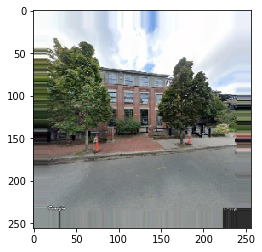

In [21]:
store = next(train_generator)
plt.imshow(store[0][2]);

In [22]:
# training parameters
epochs = 20
val_steps = test_data.shape[0]//val_batch_size

# train model
history = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator, 
                              validation_steps=val_steps,
                              epochs=epochs,
                              steps_per_epoch=np.ceil(train_data.shape[0]//batch_size),
                              verbose=1)

Epoch 1/20
11/11 [==============================] - 31s 3s/step - loss: 1.3466 - acc: 0.3495 - val_loss: 1.1273 - val_acc: 0.3802
Epoch 2/20
11/11 [==============================] - 24s 2s/step - loss: 1.1750 - acc: 0.4805 - val_loss: 1.1392 - val_acc: 0.3672
Epoch 3/20
11/11 [==============================] - 17s 2s/step - loss: 1.0686 - acc: 0.5270 - val_loss: 1.1859 - val_acc: 0.3724
Epoch 4/20
11/11 [==============================] - 17s 2s/step - loss: 1.0103 - acc: 0.5959 - val_loss: 1.2890 - val_acc: 0.3594
Epoch 5/20
11/11 [==============================] - 15s 1s/step - loss: 0.9657 - acc: 0.6626 - val_loss: 1.3697 - val_acc: 0.3464
Epoch 6/20
11/11 [==============================] - 17s 2s/step - loss: 0.8728 - acc: 0.7060 - val_loss: 1.4321 - val_acc: 0.3594
Epoch 7/20
11/11 [==============================] - 17s 2s/step - loss: 0.8388 - acc: 0.7504 - val_loss: 1.4863 - val_acc: 0.3464
Epoch 8/20
11/11 [==============================] - 14s 1s/step - loss: 0.8395 - acc: 0.79

In [23]:
hist = {}
for key in history.history.keys():
    hist[key] = history.history[key] #+ history1.history[key] 

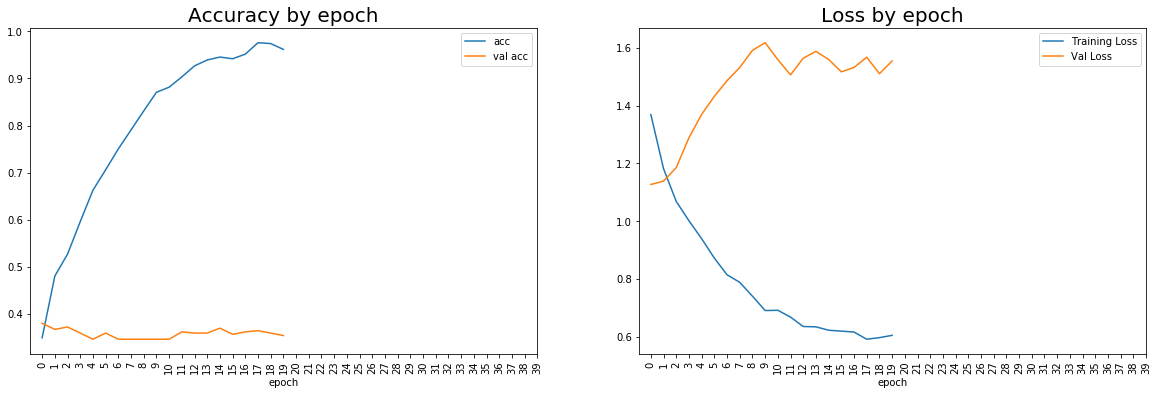

In [24]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(hist['acc'], label = 'acc')
plt.plot(hist['val_acc'], label = 'val acc')
plt.title('Accuracy by epoch', fontsize = 20)
plt.xticks(np.arange(0,40), rotation = 90);plt.xlabel('epoch')
plt.legend();

plt.subplot(1,2,2)
plt.plot(hist['loss'], label = 'Training Loss')
plt.plot(hist['val_loss'], label = 'Val Loss')
plt.title('Loss by epoch', fontsize = 20)
plt.xticks(np.arange(0,40), rotation = 90); plt.xlabel('epoch')
plt.legend();

In [ ]:
# addresses_gsv_filename = ['1_ESSEX_ST.jpg', '8_GILMAN_ST.jpg', '9_MELVILLE_RD.jpg','10_CENTRAL_ST.jpg',
#                          '14_MANSFIELD_ST.jpg']
# pred_sample = sample[sample.gsv_filename.isin(addresses_gsv_filename)].drop_duplicates()
# pred_sample
# # model.predict_generator(
# #     generator_three_inputs(pred_sample, tabular_df, 
# #                             tabular_predictor_cols = tabular_predictor_cols,            
# #                            aerial_dir = '../data/training/aerial_images/', 
# #                            gsv_dir ='../data/training/sv_images/', 
# #                            batch_size = pred_sample.shape[0], 
# #                            gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4) , 
# #                            y_column = 'temp_label'), steps = 1)

### Make predictions

In [25]:
## Generator change the 
gen_obj = ImageDataGenerator(rescale=1.0/255.0)
train_generator = gen_obj.flow_from_dataframe(train_data, 
                                            directory = image_dir,  
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=train_data.shape[0], 
                                            shuffle=False, 
                                            seed=10)

train_preds = model.predict_generator(train_generator, steps = 1)
train_data['predicted_label'] = np.argmax(train_preds, axis = 1)
sum(train_data[y_column].astype('int') == train_data.predicted_label.astype('int'))/len(train_data)

Found 705 validated image filenames belonging to 3 classes.


0.4524822695035461

In [26]:
test_gen_obj = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen_obj.flow_from_dataframe(test_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(sv_image_dim[0], sv_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=test_data.shape[0], 
                                            shuffle=False,
                                            seed=10)

test_preds = model.predict_generator(test_generator, steps = 1)
test_data['predicted_label'] = np.argmax(test_preds, axis = 1)
sum(test_data.three_class_label.astype('int') == test_data.predicted_label.astype('int'))/len(test_data)

Found 401 validated image filenames belonging to 3 classes.


0.4513715710723192

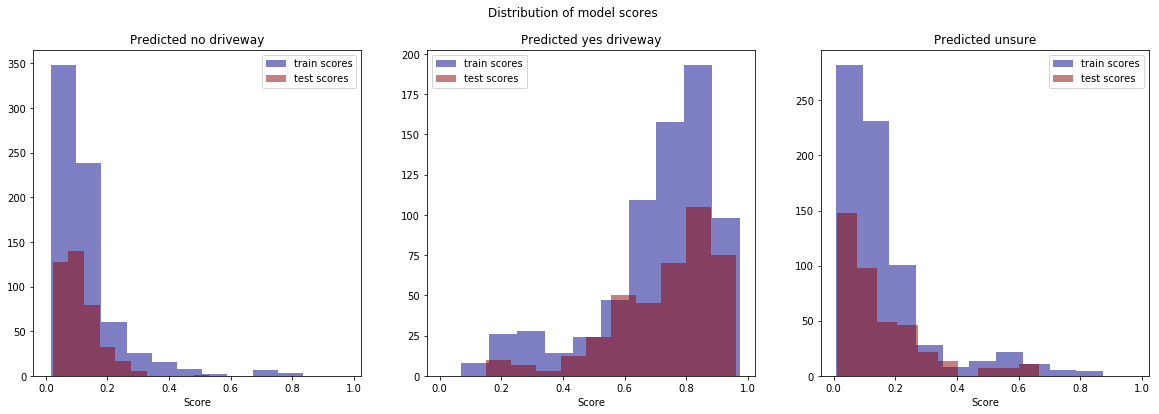

In [28]:
# binary prediction
if len(train_preds.shape) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))

    ax.hist(train_preds, color='darkblue', alpha=0.5, label='train scores')
    ax.hist(test_preds, color='darkred', alpha=0.5, label='test scores')
    ax.legend()
    ax.set_xlabel('Score')
    ax.set_title('Distribution of model scores');
    
elif len(train_preds.shape) > 1:
    label_map = {0: 'Predicted no driveway', 1: 'Predicted yes driveway', 2: 'Predicted unsure'}
    fig, ax = plt.subplots(1, train_preds.shape[1], sharex=True, figsize=(20,6))
    
    for i in range(train_preds.shape[1]):
        ax[i].hist(train_preds[:,i], color='darkblue', alpha=0.5, label='train scores')
        ax[i].hist(test_preds[:,i], color='darkred', alpha=0.5, label='test scores')
        ax[i].legend()
        ax[i].set_xlabel('Score')
        ax[i].set_title(label_map[i])
    fig.suptitle('Distribution of model scores');

In [29]:
# (train_data['three_class_label'] == train_data['predicted_label'])

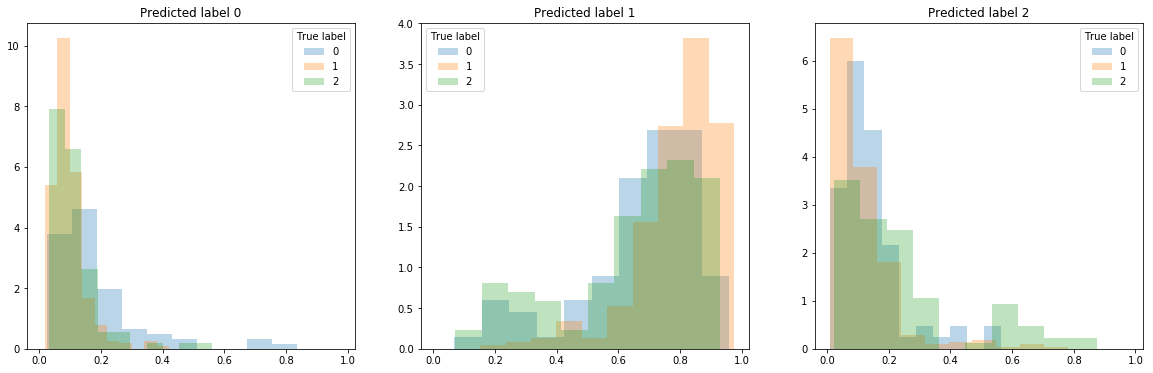

In [31]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,6))
for i in range(train_preds.shape[1]):
    for lab in ['0','1','2']:
        ax[i].hist(train_preds[train_data[y_column]==lab,i], alpha=0.3, density=True, label=lab)
    ax[i].legend(title='True label');
    ax[i].set_title('Predicted label ' + str(i))

### Save Models

In [32]:
model.save('../models/sv_transfer_model_learningratescheduler.h5')

In [33]:
model.save_weights('../models/sv_transfer_model_weights_learningratescheduler.h5')

In [ ]:
chk = load_model('../models/sv_transfer_model_learningratescheduler.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [50]:
# chk.predict_generator(train_generator)